# Reservoir Computer for Lorenz (1963) model prediction 

First, we compute the data set based on forward integration of this model. 

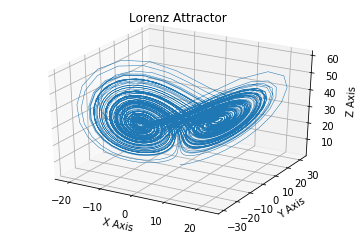

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.02
num_steps = 6250

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Definition of parameters of the Reservoir Computer: 
start_node = end_node, step = 1; 
regression_parameter = beta  (regularization parameter in notes);  
bias = 0, leakage_rate = 1;  
init: # time steps not used from the beginning; 
train - init: # time steps used for training;
test: # time steps used for testing;
error: # time steps used for error computation over the testing interval 

In [5]:
#! /usr/bin/env python3
# -*- coding: utf-8

import numpy as np
import networkx as nx
import json
import atexit
import os.path
from decimal import Decimal
from collections import OrderedDict
import datetime
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt

# if config file not exists, use this default config
default_config = """{
  "input": {
    "nodes": 3,
    "functions": 
      [
        "lambda x: xs",
        "lambda x: ys",
        "lambda x: zs"
      ],
    "length": 6250
  },
  "reservoir": {
    "start_node": 300,
    "end_node": 300,
    "step": 1,
    "degree_function": "lambda x: 6",
    "sigma": 0.1,
    "bias": 0.0,
    "spectral_radius": 1.25,
    "leakage_rate": 1.0,
    "regression_parameter": 5.0e-09
  },
  "output": {
    "nodes": 3
  },
  "training": {
    "init": 0,
    "train": 5000,
    "test": 1250,
    "error": 1250
  }
}"""

Define the Reservoir class

In [6]:
class Reservoir:
    def __init__(self):
        config_file_name = 'reservoir.config'
        global config
        if os.path.isfile(config_file_name):
            with open(config_file_name) as config_file:
                config = json.load(config_file, object_pairs_hook=OrderedDict)
        else:
            config = json.loads(default_config, object_pairs_hook=OrderedDict)
            print('Config file not exist, using default config instead!')

        # Input layer
        self.M = config["input"]["nodes"]
        self.input_len = config["input"]["length"]
        self.input_func = []
        dataset = []
        for i in range(self.M):
            self.input_func.append(eval(config["input"]["functions"][i]))
            dataset.append(self.input_func[i](
                np.arange(self.input_len) / self.input_len))
        self.dataset = np.array(list(zip(*dataset))).T # shape = (M, length)

        # Reservoir layer
        self.start_node = config["reservoir"]["start_node"]
        self.N = self.start_node
        self.step = config["reservoir"]["step"]
        self.end_node = config["reservoir"]["end_node"]
        self.degree_func = eval(config["reservoir"]["degree_function"])
        self.D = self.degree_func(self.start_node)
        self.sigma = config["reservoir"]["sigma"]
        self.bias = config["reservoir"]["bias"]
        self.alpha = config["reservoir"]["leakage_rate"]
        self.sr = config["reservoir"]["spectral_radius"]
        self.beta = config["reservoir"]["regression_parameter"]

        # Output layer
        self.P = config["output"]["nodes"]

        # Training relevant
        self.init_len = config["training"]["init"]
        self.train_len = config["training"]["train"]
        self.test_len = config["training"]["test"]
        self.error_len = config["training"]["error"]


    def train(self):
        # collection of reservoir state vectors
        self.R = np.zeros(
            (1 + self.N + self.M, self.train_len - self.init_len))
        # collection of input signals
        self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset))
        self.r = np.zeros((self.N, 1))
        np.random.seed(42)
        self.Win = np.random.uniform(-self.sigma,
                                     self.sigma, (self.N, self.M + 1))
        # TODO: the values of non-zero elements are randomly drawn from uniform dist [-1, 1]
        g = nx.erdos_renyi_graph(self.N, self.D / self.N, 42, True)
        # nx.draw(g, node_size=self.N)
        self.A = nx.adjacency_matrix(g).todense()
        # spectral radius: rho
        self.rho = max(abs(np.linalg.eig(self.A)[0]))
        self.A *= self.sr / self.rho
        # run the reservoir with the data and collect r
        for t in range(self.train_len):
            u = np.vstack((x[t] for x in self.dataset))
            # r(t + \Delta t) = (1 - alpha)r(t) + alpha * tanh(A * r(t) + Win * u(t) + bias)
            self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,
                                                                             self.r) + np.dot(self.Win, np.vstack((self.bias, u))))
            if t >= self.init_len:
                self.R[:, [t - self.init_len]
                       ] = np.vstack((self.bias, u, self.r))[:, 0]
        # train the output
        R_T = self.R.T  # Transpose
        # Wout = (s * r^T) * ((r * r^T) + beta * I)
        self.Wout = np.dot(np.dot(self.S, R_T), np.linalg.inv(
            np.dot(self.R, R_T) + self.beta * np.eye(self.M + self.N + 1)))

    def _run(self):
        # run the trained ESN in alpha generative mode. no need to initialize here,
        # because r is initialized with training data and we continue from there.
        self.S = np.zeros((self.P, self.test_len))
        u = np.vstack((x[self.train_len] for x in self.dataset))
        for t in range(self.test_len):
            # r(t + \Delta t) = (1 - alpha)r(t) + alpha * tanh(A * r(t) + Win * u(t) + bias)
            self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,
                                                                             self.r) + np.dot(self.Win, np.vstack((self.bias, u))))
            s = np.dot(self.Wout, np.vstack((self.bias, u, self.r)))
            self.S[:, t] = np.squeeze(np.asarray(s))
            # use output as input
            u = s
        # compute Root Mean Square (RMS) error for the first self.error_len time steps
        self.RMS = []
        for i in range(self.P):
          self.RMS.append(sum(np.square(
            self.dataset[i, self.train_len+1: self.train_len+self.error_len+1] - self.S[i, 0: self.error_len])) / self.error_len)

    def draw(self):
      plt.subplots(1, self.M, figsize = (20,6) )
      plt.suptitle('N = ' + str(self.N) + ', Degree = %.5f' % (self.D))
      for i in range(self.M):
        ax = plt.subplot(1, self.M, i + 1)
        plt.text(0.5, -0.1, 'RMS = %.5e' % self.RMS[i], size=10, ha="center", transform=ax.transAxes)
        plt.plot(self.S[i], label = 'prediction')
        plt.plot(self.dataset[i][self.train_len + 1 : self.train_len + self.test_len + 1], label = 'input signal')
        plt.title(config["input"]["functions"][i])
        plt.legend(loc = 'upper right')
        # plt.savefig('N = ' + str(self.N), dpi = 300)
      plt.show()
    
    def run(self):
        with open('reservoir.output', 'a') as output:
            prompt = '# ' + str(datetime.datetime.now()) + \
                '\n' + json.dumps(config, indent=4) + '\n'
            print(prompt, end='')
            output.write(prompt)
            for i in range(self.start_node, self.end_node + 1, self.step):
                self.N = i
                self.D = self.degree_func(self.N)
                self.train()
                self._run()
                for j in range(1):
                  res = 'N = ' + str(self.N) + ', D = ' + '%.15f' % self.D + \
                      ', RMS = ' + '%.15e' % Decimal(self.RMS[j]) + '\n' + \
                      ', rho = ' + str(self.sr)
                  print(res, end='')
                output.write(res)
                config["reservoir"]["start_node"] = i
                self.draw()


# Invoke automatically when exit, write the progress back to config file
def exit_handler():
    global config
    with open('reservoir.config', 'w') as config_file:
        config_file.write(json.dumps(config, indent = 4))
    print('Program finished! Current node = ' +
          str(config["reservoir"]["start_node"]))


Now run the Reservoir Computer for the Lorenz (1963) model data. Study the effect of the 
reservoir size on the predictions. 

Config file not exist, using default config instead!
# 2022-04-22 17:06:04.027473
{
    "input": {
        "nodes": 3,
        "functions": [
            "lambda x: xs",
            "lambda x: ys",
            "lambda x: zs"
        ],
        "length": 6250
    },
    "reservoir": {
        "start_node": 300,
        "end_node": 300,
        "step": 1,
        "degree_function": "lambda x: 6",
        "sigma": 0.1,
        "bias": 0.0,
        "spectral_radius": 1.25,
        "leakage_rate": 1.0,
        "regression_parameter": 5e-09
    },
    "output": {
        "nodes": 3
    },
    "training": {
        "init": 0,
        "train": 5000,
        "test": 1250,
        "error": 1250
    }
}
N = 300, D = 6.000000000000000, RMS = 1.062396872230190e+02
, rho = 1.25

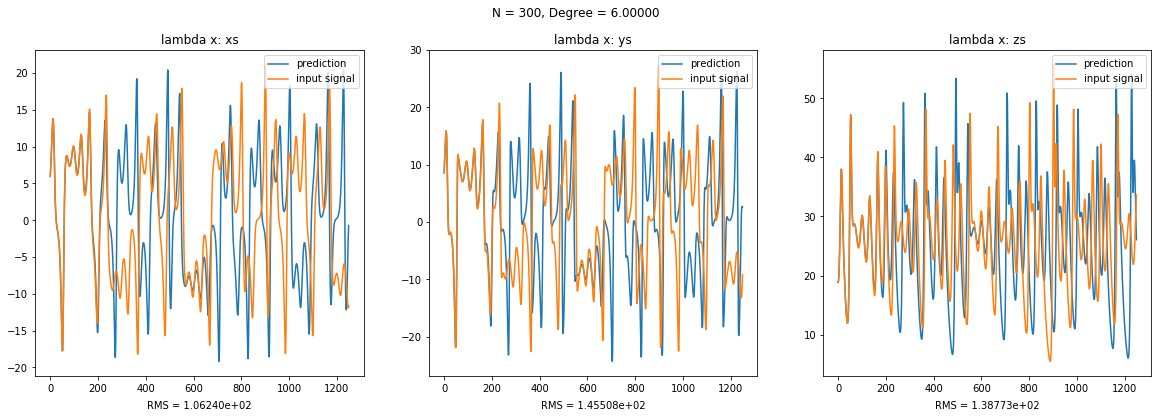

In [7]:
if __name__ == '__main__':
    atexit.register(exit_handler)
    r = Reservoir()
    r.run()